# Kütüphaneleri import et

In [ ]:
!pip install monai -q

import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    Resize,
    ToTensor,
)
from monai.utils import set_determinism
import cv2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.5 MB/s eta 0:00:00


# Veriyi Yükle

In [ ]:
# !pip install rarfile -q

# import gdown
# import rarfile
# import os

# # Dosya ID'si ve hedef dosya adı
# file_id = "1fyqO-phKJ6umFUv-pJH5VzZyfANnzfhe"
# output_file = "/content/drive/MyDrive/Colab Notebooks/Biyomedikal/2.Quiz/data/BeyinInmeVerisi.rar"
# extract_folder = "/content/drive/MyDrive/Colab Notebooks/Biyomedikal/2.Quiz/data/BeyinInmeVerisi"

# # Google Drive'dan dosyayı indir
# gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file, quiet=False)

# # RAR dosyasını çıkart
# if not os.path.exists(extract_folder):
#     os.makedirs(extract_folder)

# with rarfile.RarFile(output_file) as rf:
#     rf.extractall(extract_folder)

# print(f"Dosya '{output_file}' indirildi ve '{extract_folder}' klasörüne çıkarıldı.")

# Seed belirleyerek deterministik eğitimi etkinleştirin

In [ ]:
set_determinism(seed=42)

# Veri kümesi klasörlerinden görüntü dosya adlarını okuma

In [ ]:
data_dir = "/content/drive/MyDrive/Colab Notebooks/Biyomedikal/2.Quiz/data/BeyinInmeVerisi"

class_names = sorted(x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [os.path.join(data_dir, class_names[i], x) for x in os.listdir(os.path.join(data_dir, class_names[i]))]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 6947
Image dimensions: 512 x 512
Label names: ['0', '1']
Label counts: [4564, 2383]


# Görselleştirmek ve kontrol etmek için veri kümesinden rastgele resimler seçin

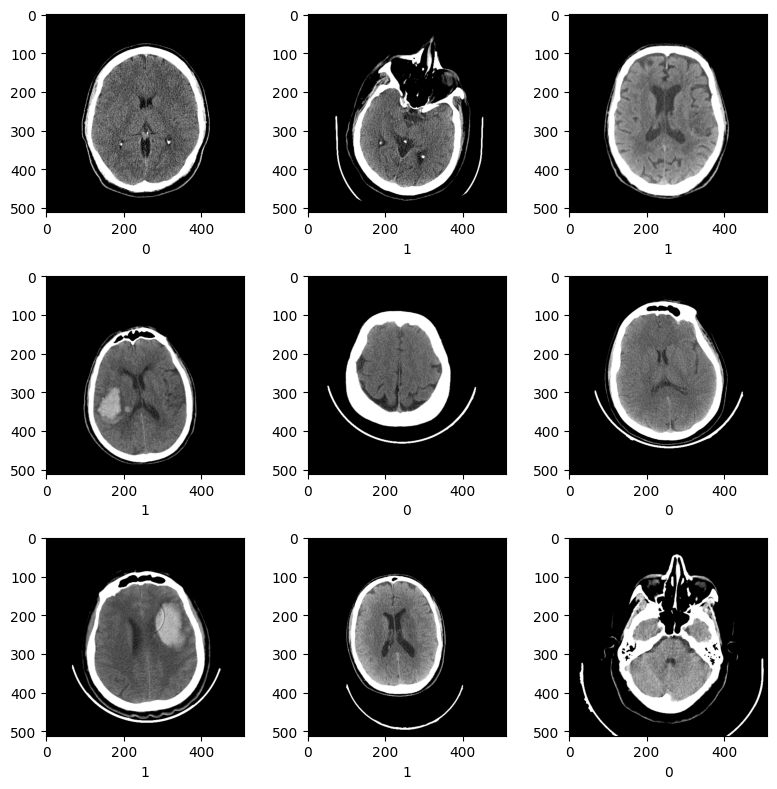

In [ ]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

# Eğitim, doğrulama ve test veri listelerini hazırlayın
Veri setinin %10'unu doğrulama, %10'unu da test olarak rastgele seçin.


In [ ]:
val_frac = 0.1
test_frac = 0.1
length = len(image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]

print(f"Training count: {len(train_x)}, Validation count: " f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 5559, Validation count: 694, Test count: 694


# Verileri önceden işlemek için MONAI dönüşümlerini, Dataset ve Dataloader'ı tanımlama

In [ ]:
# LoadPNGImage Sınıfı
class LoadPNGImage:
    def __call__(self, img_path):
        # PNG formatındaki görüntüyü okuma (tek kanal olarak)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Gri tonlamalı olarak oku
        if image is None:
            raise ValueError(f"Dosya okunamadı: {img_path}")

        # (H, W) formatını (1, H, W) formatına dönüştür
        image = np.expand_dims(image, axis=0)  # (H, W) → (1, H, W)
        return image.astype(np.float32)  # float32 formatında döndür

In [ ]:
train_transforms = Compose(
    [
        LoadPNGImage(),
        Resize(spatial_size=(512, 512)),
        # EnsureChannelFirst(),
        ScaleIntensity(),
        ToTensor(),
    ]
)

val_transforms = Compose([LoadPNGImage(),
                          Resize(spatial_size=(512, 512)),
                          # EnsureChannelFirst(),
                          ScaleIntensity(),
                          ToTensor(),
                          ])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

In [ ]:
class BrainStrokeDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

# Assuming you have defined train_transforms and val_transforms
train_ds = BrainStrokeDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=8)

val_ds = BrainStrokeDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(val_ds, batch_size=16, num_workers=8)

test_ds = BrainStrokeDataset(test_x, test_y, val_transforms)
test_loader = DataLoader(test_ds, batch_size=16, num_workers=8)

# Network ve Optimizer'ı Tanımla

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 12
val_interval = 1
auc_metric = ROCAUCMetric()

# Model eğitimi

In [ ]:
import os
import torch
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from monai.data import decollate_batch

best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print(f"Epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    epoch_len = len(train_ds) // train_loader.batch_size

    # Progress bar for training
    train_progress_bar = tqdm(train_loader, desc="Training", unit="batch", total=epoch_len)

    for batch_data in train_progress_bar:
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # Update progress bar description with current loss
        train_progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

        # Add to tensorboard
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + train_progress_bar.n)

    train_progress_bar.close()

    # Calculate and display average loss for this epoch
    avg_epoch_loss = epoch_loss / epoch_len
    epoch_loss_values.append(avg_epoch_loss)
    print(f"Average training loss: {avg_epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        print("Validating...")
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)

            # Progress bar for validation
            val_progress_bar = tqdm(val_loader, desc="Validation", unit="batch")

            for val_data in val_progress_bar:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)

            val_progress_bar.close()

            # Calculate metrics
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)

            # Calculate accuracy
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)

            # Save model if better
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join("/content/drive/MyDrive/Colab Notebooks/Biyomedikal/2.Quiz", "classification_model.pth"))
                print("✅ Saved new best metric model")

            # Print validation results
            print(f"AUC: {result:.4f} | Accuracy: {acc_metric:.4f} | Best AUC: {best_metric:.4f} at epoch {best_metric_epoch}")
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

    print("-" * 40)

print(f"Training completed! Best AUC: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()

Epoch 1/12


Training: 348batch [07:02,  1.21s/batch, loss=0.6677]


Average training loss: 0.5568
Validating...


Validation: 100%|██████████| 44/44 [00:51<00:00,  1.17s/batch]


✅ Saved new best metric model
AUC: 0.8997 | Accuracy: 0.8516 | Best AUC: 0.8997 at epoch 1
----------------------------------------
Epoch 2/12


Training: 348batch [05:27,  1.06batch/s, loss=0.9961]


Average training loss: 0.3974
Validating...


Validation: 100%|██████████| 44/44 [00:10<00:00,  4.30batch/s]


✅ Saved new best metric model
AUC: 0.9344 | Accuracy: 0.8775 | Best AUC: 0.9344 at epoch 2
----------------------------------------
Epoch 3/12


Training: 348batch [05:27,  1.06batch/s, loss=0.5497]


Average training loss: 0.3394
Validating...


Validation: 100%|██████████| 44/44 [00:10<00:00,  4.26batch/s]


✅ Saved new best metric model
AUC: 0.9456 | Accuracy: 0.8905 | Best AUC: 0.9456 at epoch 3
----------------------------------------
Epoch 4/12


Training: 348batch [05:27,  1.06batch/s, loss=0.8329]


Average training loss: 0.3077
Validating...


Validation: 100%|██████████| 44/44 [00:10<00:00,  4.27batch/s]


✅ Saved new best metric model
AUC: 0.9605 | Accuracy: 0.9049 | Best AUC: 0.9605 at epoch 4
----------------------------------------
Epoch 5/12


Training: 348batch [05:27,  1.06batch/s, loss=0.5202]


Average training loss: 0.2568
Validating...


Validation: 100%|██████████| 44/44 [00:10<00:00,  4.26batch/s]


✅ Saved new best metric model
AUC: 0.9647 | Accuracy: 0.9179 | Best AUC: 0.9647 at epoch 5
----------------------------------------
Epoch 6/12


Training: 348batch [05:27,  1.06batch/s, loss=0.4538]


Average training loss: 0.2217
Validating...


Validation: 100%|██████████| 44/44 [00:10<00:00,  4.28batch/s]


✅ Saved new best metric model
AUC: 0.9722 | Accuracy: 0.9150 | Best AUC: 0.9722 at epoch 6
----------------------------------------
Epoch 7/12


Training: 348batch [05:27,  1.06batch/s, loss=0.1099]


Average training loss: 0.1800
Validating...


Validation: 100%|██████████| 44/44 [00:10<00:00,  4.27batch/s]


AUC: 0.9661 | Accuracy: 0.8545 | Best AUC: 0.9722 at epoch 6
----------------------------------------
Epoch 8/12


Training: 348batch [05:27,  1.06batch/s, loss=0.0550]


Average training loss: 0.1423
Validating...


Validation: 100%|██████████| 44/44 [00:10<00:00,  4.27batch/s]


AUC: 0.9708 | Accuracy: 0.9207 | Best AUC: 0.9722 at epoch 6
----------------------------------------
Epoch 9/12


Training: 348batch [05:27,  1.06batch/s, loss=0.2124]


Average training loss: 0.1333
Validating...


Validation: 100%|██████████| 44/44 [00:10<00:00,  4.27batch/s]


✅ Saved new best metric model
AUC: 0.9759 | Accuracy: 0.9366 | Best AUC: 0.9759 at epoch 9
----------------------------------------
Epoch 10/12


Training: 348batch [05:27,  1.06batch/s, loss=0.0561]


Average training loss: 0.0882
Validating...


Validation: 100%|██████████| 44/44 [00:10<00:00,  4.28batch/s]


✅ Saved new best metric model
AUC: 0.9772 | Accuracy: 0.9265 | Best AUC: 0.9772 at epoch 10
----------------------------------------
Epoch 11/12


Training: 348batch [05:27,  1.06batch/s, loss=0.0255]


Average training loss: 0.0837
Validating...


Validation: 100%|██████████| 44/44 [00:10<00:00,  4.27batch/s]


✅ Saved new best metric model
AUC: 0.9777 | Accuracy: 0.8429 | Best AUC: 0.9777 at epoch 11
----------------------------------------
Epoch 12/12


Training: 348batch [05:27,  1.06batch/s, loss=0.0267]


Average training loss: 0.0698
Validating...


Validation: 100%|██████████| 44/44 [00:10<00:00,  4.26batch/s]


✅ Saved new best metric model
AUC: 0.9861 | Accuracy: 0.9308 | Best AUC: 0.9861 at epoch 12
----------------------------------------
Training completed! Best AUC: 0.9861 at epoch: 12


 # Plot the loss and metric

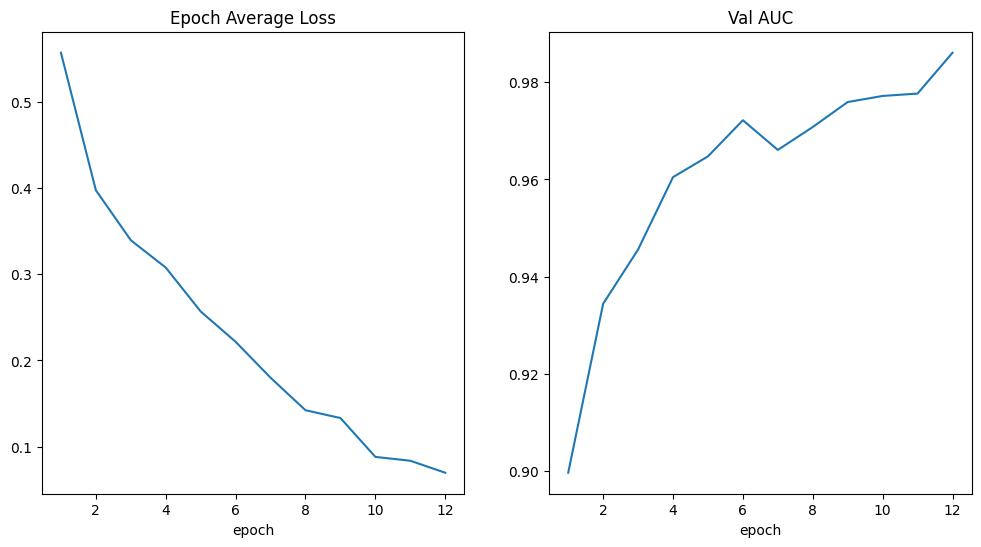

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

# Modeli test veri kümesinde değerlendirin

In [ ]:
model.load_state_dict(torch.load(os.path.join("/content/drive/MyDrive/Colab Notebooks/Biyomedikal/2.Quiz", "classification_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

           0     0.9371    0.9896    0.9627       482
           1     0.9730    0.8491    0.9068       212

    accuracy                         0.9467       694
   macro avg     0.9551    0.9193    0.9347       694
weighted avg     0.9481    0.9467    0.9456       694



# Modeli test veri kümesi üzerinde çalıştırıp ortalama test accuracy skorunu hesaplama

In [ ]:
model.eval()  # Modeli değerlendirme moduna al
test_correct = 0
test_total = 0

with torch.no_grad():
    for batch_data in test_loader:
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        outputs = model(inputs)
        # Tahmin edilen sınıfı almak için argmax kullanılır
        predicted = torch.argmax(outputs, dim=1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.9467
